# Tutorial: webscraping en LinkedIn con python

Introduccion mamalon

Este tutorial se realizo en un equipo de computo con Ubuntu 16.04 y con Python 3.5

# Background

<div style="width:image width px; font-size:80%; text-align:center;"><img src="img/interes_tiempo.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />Interes a lo largo del tiempo para el temino <strong>web scraping</strong></div>

La principal razon por la que se eligio hacer este tutorial con python es por su popularidad, y por su facilidad de implementacion

<div style="width:image width px; font-size:80%; text-align:center;"><img src="img/consultas_relacionadas.png" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />Consultas relacionadas a <strong>web scraping</strong></div>

# Manos a la obra!

## Ambientacion

### Instalar selenium

Para instalar selenium, bastara con ejecutar el comando: <br/>
<code>pip install -U selenium</code> </br>

Selenium es un entorno de pruebas de software para aplicaciones basadas en la web. En otras palabras es posible automatizar la realizacion de ciertas acciones en aplicaciones web, nosotros usaremos esta habilidad para simular hacer busquedas en la plataforma.

Selenium requiere drivers para interacturar como un navegador. Firefox por ejemplo requiere geckodriver, que necesita ser instalado antes de poder correr con selenium. Asegurate de agregarlo a tu PATH, por ejemplo para sistemas linux en /usr/bin o /usr/local/bin o agregalo al ~/.bashrc

Te adjuntamos las ligas en la tabla de abajo

<table>
<colgroup>
<col>
<col>
</colgroup>
<tbody>
<tr><td><strong>Chrome</strong>:</td>
<td><a href="https://sites.google.com/a/chromium.org/chromedriver/downloads" rel="nofollow">https://sites.google.com/a/chromium.org/chromedriver/downloads</a></td>
</tr>
<tr><td><strong>Edge</strong>:</td>
<td><a href="https://developer.microsoft.com/en-us/microsoft-edge/tools/webdriver/" rel="nofollow">https://developer.microsoft.com/en-us/microsoft-edge/tools/webdriver/</a></td>
</tr>
<tr><td><strong>Firefox</strong>:</td>
<td><a href="https://github.com/mozilla/geckodriver/releases" rel="nofollow">https://github.com/mozilla/geckodriver/releases</a></td>
</tr>
<tr><td><strong>Safari</strong>:</td>
<td><a href="https://webkit.org/blog/6900/webdriver-support-in-safari-10/" rel="nofollow">https://webkit.org/blog/6900/webdriver-support-in-safari-10/</a></td>
</tr>
</tbody>
</table>

## Proceso

### Paso 1: Importar librerias

En caso de marcar error en alguna libreria, basta con ejecutar 

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import pickle
from functools import reduce

### Paso 2: Generar Cookies con el Login

Una vez instaladas las librerias y los drivers, necesitamos una sesion para poder navegar libremente por la plataforma, para eso es necesario abrir la sesion con el driver y posteriormente guardar los cookies generados con la libreria:
<div style="width:image width px; font-size:80%; text-align:center;"><img src="img/login_linked.gif" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />Ejemplo del proceso a seguir para guardar cookie</div>

In [2]:
# Funcion para guardar las cookies
def save_cookie(driver, path):
    with open(path, "wb") as filehandler:
        pickle.dump(driver.get_cookies(), filehandler)

# Ruta de la pagina para hacer login
login_path = "https://www.linkedin.com"
# Nombre con el que guardaremos la cookie generada
cookie_name = "cookie_link.pkl"
# Generando una sesion de Firefox con selenim
driver = webdriver.Firefox()
driver.implicitly_wait(30)
driver.get(login_path)

In [3]:
save_cookie(driver, cookie_name)

### Paso 3: Cargar cookie y realizar una busqueda en LinkendIn

In [13]:
from selenium.webdriver.common.keys import Keys

from selenium.webdriver.common.action_chains import ActionChains
# Funcion para cargar cookie guardada
def load_cookie(driver, path):
     with open(path, 'rb') as cookiesfile:
        cookies = pickle.load(cookiesfile)
        for cookie in cookies:
            driver.add_cookie(cookie)
# Este codigo lo obtuve revisando la liga que genera linkendIn cada vez que filtramos por ciudad
places = {"cdmx":"%5B%22mx%3A5921%22%5D"}
# Palabras que queremos buscar
keywords = ["ceo", "developer"]

# Genera la ruta que abriremos con el driver
# La funcion usa la teconologia de busqueda implementada por linkedIn
#  https://www.linkedin.com/help/linkedin/answer/76723/usa-la-busqueda-booleana-en-linkedin?lang=es
def _search_people_link(place, keywords, num_page):
    keywords_string = reduce(lambda a,b: "{} O {}".format(a, b), keywords)
    keywords_string = keywords_string.replace(" ","%20")
    return "https://www.linkedin.com/search/results/people/?facetGeoRegion={}&keywords={}&origin=FACETED_SEARCH&page={}".format(place, keywords_string, num_page)
def get_contacts(driver):
    content = BeautifulSoup(driver.page_source, 'lxml')
    contacts = content.findAll("div", {"class": "search-result__info"})
    array_contacts = []
    for contact in contacts:
        con={}
        con["name"] = contact.findAll("span", {"class": "name actor-name"} )[0].contents[0]
        con["position"] = contact.findAll("span", {"dir": "ltr"})[0].contents[0]
        con["location"] = contact.findAll("span", {"dir": "ltr"})[1].contents[0]
        try:
            con["distance"] = contact.findAll("span", {"class": "distance-badge separator ember-view"})[0]\
            .findAll("span", {"class": "dist-value"})[0].contents[0]
        except:
            con["distance"] = None
        con["page"] = page
        array_contacts.append(con)
    return array_contacts

# Creando sesion con Firefox
driver = webdriver.Firefox()
driver.implicitly_wait(30)
driver.get(login_path)
# Recuperando sesion con las cookies
load_cookie(driver, cookie_name)
# Esperando a que la plataforme cargue la sesion
driver.implicitly_wait(500)

contacts = []
past_num = 0
for page in range(1,10000):
    # Generando url con busqueda
    url = _search_people_link(places["cdmx"], keywords, page)
    driver.get(url)
    driver.implicitly_wait(100)
    # Javascript renderiza solo lo que el usuario puede ver
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight*(1/ 5));")
    driver.implicitly_wait(100)
    driver.execute_script("window.scrollTo( document.body.scrollHeight*(1/ 5), document.body.scrollHeight*(2/ 5));")
    driver.implicitly_wait(100)
    driver.execute_script("window.scrollTo(document.body.scrollHeight*(2/ 5), document.body.scrollHeight*(3/ 5));")
    driver.implicitly_wait(100)
    driver.execute_script("window.scrollTo(document.body.scrollHeight*(3/ 5), document.body.scrollHeight);")
    driver.implicitly_wait(100)
    contacts = contacts + get_contacts(driver)
    driver.implicitly_wait(100)
    # Si ya no hay contactos que mostrar el script termina
    if(past_num == len(contacts)):
        break;
    past_num=len(contacts)
    

<div style="width:image width px; font-size:80%; text-align:center;"><img src="img/automated_linkedIn.gif" alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" />Busqueda automatizada</div>

# Paso 3: persistiendo la informacion

En este punto tendriamos la informacion en un array de python, el siguiente paso es poder guardarlo en un csv para su posterior explotacion

In [18]:
import pandas as pd
dataframe = pd.DataFrame(contacts)
dataframe.to_csv("linkedIn_2018-01-11")

In [39]:
dataframe.drop(["name", "position"], axis=1).head()

,distance,location,page
0,2º,"Ciudad de México y alrededores, México",1
1,2º,"Ciudad de México y alrededores, México",1
2,2º,"Ciudad de México y alrededores, México",1
3,2º,"Ciudad de México y alrededores, México",1
4,2º,"Ciudad de México y alrededores, México",1


# Paso extra: graficando resultados

Algo interesante acerca de este metodo es que requiere que los pasos para interactuar en la pagina esten bien calibrados, si no se realiza ese paso es posible que al obtener la informacion esta venga incompleta, como una recomendacion si piensas usar un metodo similar toma en cuenta el tiempo y animacion de javascript en las paginas

In [19]:
from matplotlib import pyplot as plt

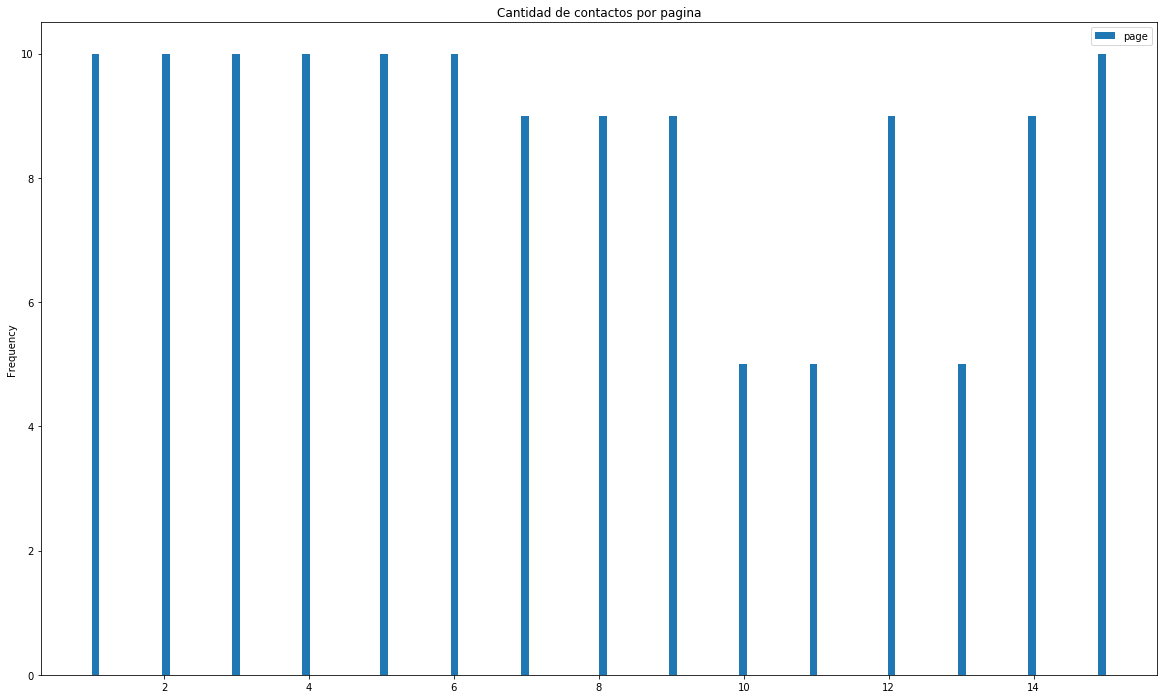

In [34]:
dataframe.plot.hist("page", figsize=(20, 12), bins=len(contacts))
plt.title("Cantidad de contactos por pagina")
plt.show()

# Fuentes
https://pypi.org/project/selenium/